In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.patheffects as path_effects

pd.set_option('max_columns', None)
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [2]:
#folder = 'finals_2021_1'
#path = '/home/danguyen/data/powertac/finals_2021/{}/analysis'.format(folder)
folder = 'finals_2022_1'
path = '/home/danguyen/data/powertac/finals_2022/{}'.format(folder)
cwd = Path(path)
tf_transactions = pd.read_csv(cwd/"{}.tariff-transactions.csv".format(folder), delimiter=";")


In [3]:
# remove leading and trailing whitespaces in column names and values

def rem_ws_col(df):
    df.columns = df.columns.str.strip()
    return df

def rem_ws_val(df):
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    return df

tf_transactions = rem_ws_col(tf_transactions)


tf_transactions[['broker-name', 'tariff-type', 'transaction-type']].astype(str)
tf_transactions = rem_ws_val(tf_transactions)


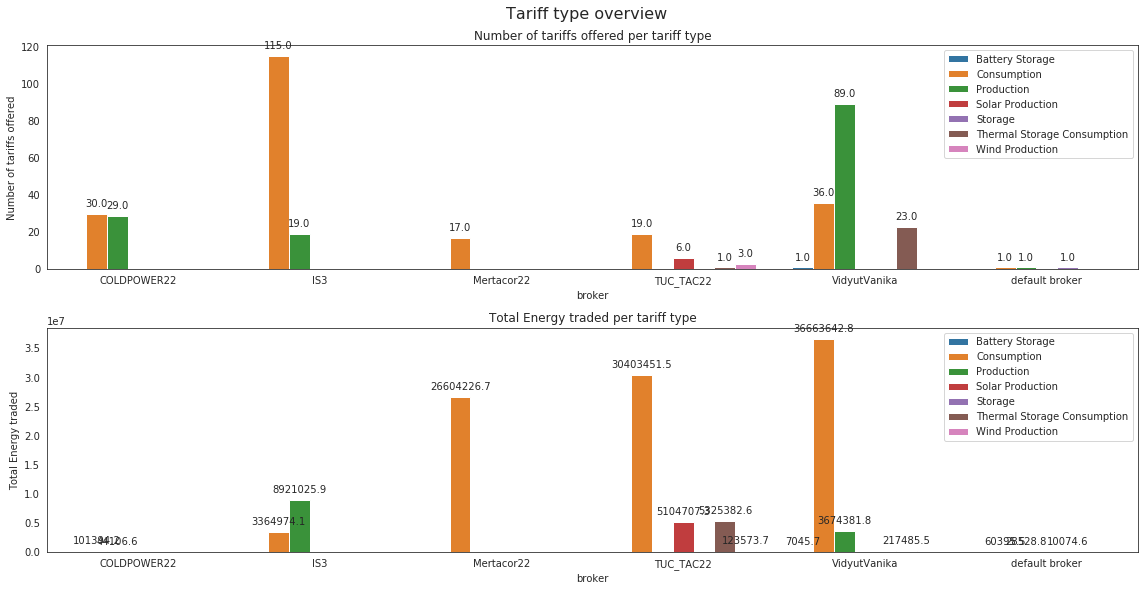

In [5]:
def add_value_labels(ax, spacing=5):
        """Add labels to the end of each bar in a bar chart.

        Arguments:
            ax (matplotlib.axes.Axes): The matplotlib object containing the axes
                of the plot to annotate.
            spacing (int): The distance between the labels and the bars.
        """

        # For each bar: Place a label
        for rect in ax.patches:
            # Get X and Y placement of label from rect.
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2

            # Number of points between bar and label. Change to your liking.
            space = spacing
            # Vertical alignment for positive values
            va = 'bottom'

            # If value of bar is negative: Place label below bar
            if y_value < 0:
                # Invert space to place label below
                space *= -1
                # Vertically align label at top
                va = 'top'

            # Use Y value as label and format number with one decimal place
            label = "{:.1f}".format(y_value)
            if label == "0.0":
                label = ""
                

            # Create annotation
            ax.annotate(
                label,                      # Use `label` as label
                (x_value, y_value),         # Place label at end of the bar
                xytext=(0, space),          # Vertically shift label by `space`
                textcoords="offset points", # Interpret `xytext` as offset in points
                ha='center',                # Horizontally center label
                va=va)                      # Vertically align label differently for
                                            # positive and negative values.

tf_type_dist = tf_transactions[['broker-name', 'tariff-id', 'tariff-type'
                                , 'transaction-kWh', 'customer-name', 'customer-count']].copy()
#tf_type_dist = tf_type_dist[tf_type_dist['customer-name'] == 'residential_ev']

tf_type_count = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'tariff-id']]
                             .groupby(by = ['broker-name', 'tariff-type'])['tariff-id'].nunique())
tf_type_count = tf_type_count.reset_index()
tf_type_count.columns = ['broker', 'tariff-type', 'count']

tf_type_energy = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'transaction-kWh']]
                              .groupby(by = ['broker-name', 'tariff-type']).sum())
tf_type_energy = tf_type_energy.reset_index()
tf_type_energy.columns = ['broker', 'tariff-type', 'energy']
tf_type_energy['energy'] = tf_type_energy['energy'].apply(lambda x: abs(x))

tf_type_count = tf_type_count.pivot(columns='tariff-type', index='broker')
tf_type_count.columns = tf_type_count.columns.swaplevel().map(' '.join)
tf_type_count = tf_type_count.replace(np.nan,0)
tf_type_count = tf_type_count.reset_index()

tf_type_energy = tf_type_energy.pivot(columns='tariff-type', index='broker')
tf_type_energy.columns = tf_type_energy.columns.swaplevel().map(' '.join)
tf_type_energy = tf_type_energy.replace(np.nan,0)
tf_type_energy = tf_type_energy.reset_index()

tf_types_count = tf_type_count.loc[:, tf_type_count.columns != "broker"]
tf_types_energy = tf_type_energy.loc[:, tf_type_energy.columns != "broker"]

df_melt_count = pd.melt(tf_type_count, id_vars=['broker'], value_vars=tf_types_count.columns.tolist())

df_melt_energy = pd.melt(tf_type_energy, id_vars=['broker'], value_vars=tf_types_energy.columns.tolist())

count_dict = {'BATTERY_STORAGE count': 'Battery Storage', 'PRODUCTION count': 'Production', 'STORAGE count': 'Storage'
                      , 'CONSUMPTION count': 'Consumption', 'THERMAL_STORAGE_CONSUMPTION count' : 'Thermal Storage Consumption'
                      , 'SOLAR_PRODUCTION count' : 'Solar Production', 'WIND_PRODUCTION count': 'Wind Production'}
energy_dict = {'BATTERY_STORAGE energy': 'Battery Storage', 'PRODUCTION energy': 'Production', 'STORAGE energy': 'Storage'
                      , 'CONSUMPTION energy': 'Consumption', 'THERMAL_STORAGE_CONSUMPTION energy' : 'Thermal Storage Consumption'
                      , 'SOLAR_PRODUCTION energy' : 'Solar Production', 'WIND_PRODUCTION energy': 'Wind Production'}

count_list = [count_dict[item] for item in tf_types_count.columns.tolist()]
energy_list = [energy_dict[item] for item in tf_types_energy.columns.tolist()]


sns.set_style("white")


f, axes = plt.subplots(2,1, figsize = (16,8))

a = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_count, ax = axes[0])
b = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_energy, ax = axes[1])

new_labels = count_list
                                               
h, l = a.get_legend_handles_labels()
a.legend(h, new_labels )

new_labels = energy_list

h, l = b.get_legend_handles_labels()
b.legend(h, new_labels)

add_value_labels(a)
add_value_labels(b)

axes[0].set(ylabel="Number of tariffs offered")
axes[1].set(ylabel="Total Energy traded")

mid = (f.subplotpars.right + f.subplotpars.left)/2

axes[0].set_title("Number of tariffs offered per tariff type")
axes[1].set_title("Total Energy traded per tariff type")

f.suptitle('Tariff type overview', y = 1.02, fontsize = 16, x = mid)
f.tight_layout()


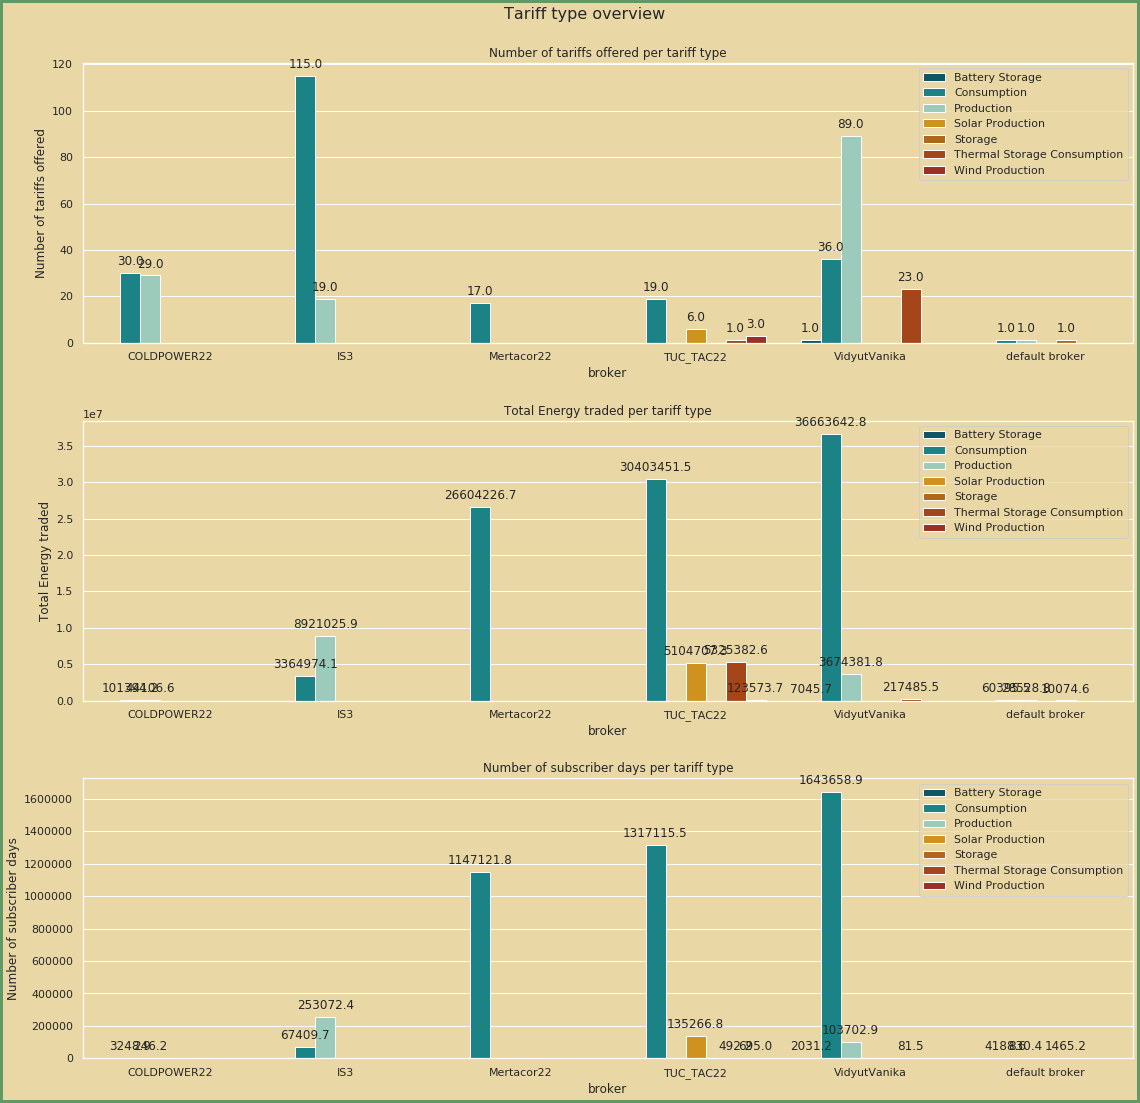

In [26]:
tf_type_dist = tf_transactions[['timeslot', 'broker-name', 'tariff-id', 'tariff-type'
                                , 'transaction-kWh', 'customer-name', 'customer-count']].copy()


tf_type_count = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'tariff-id']]
                             .groupby(by = ['broker-name', 'tariff-type'])['tariff-id'].nunique())
tf_type_count = tf_type_count.reset_index()
tf_type_count.columns = ['broker', 'tariff-type', 'count']

tf_type_count = tf_type_count.pivot(columns='tariff-type', index='broker')
tf_type_count.columns = tf_type_count.columns.swaplevel().map(' '.join)
tf_type_count = tf_type_count.replace(np.nan,0)
tf_type_count = tf_type_count.reset_index()

tf_types_count = tf_type_count.loc[:, tf_type_count.columns != "broker"]
df_melt_count = pd.melt(tf_type_count, id_vars=['broker'], value_vars=tf_types_count.columns.tolist())


#tf_type_dist = tf_type_dist[tf_type_dist['customer-name'] == 'residential_ev']
tf_type_energy = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'transaction-kWh']]
                              .groupby(by = ['broker-name', 'tariff-type']).sum())
tf_type_energy = tf_type_energy.reset_index()
tf_type_energy.columns = ['broker', 'tariff-type', 'energy']
tf_type_energy['energy'] = tf_type_energy['energy'].apply(lambda x: abs(x))

tf_type_energy = tf_type_energy.pivot(columns='tariff-type', index='broker')
tf_type_energy.columns = tf_type_energy.columns.swaplevel().map(' '.join)
tf_type_energy = tf_type_energy.replace(np.nan,0)
tf_type_energy = tf_type_energy.reset_index()

tf_types_energy = tf_type_energy.loc[:, tf_type_energy.columns != "broker"]
df_melt_energy = pd.melt(tf_type_energy, id_vars=['broker'], value_vars=tf_types_energy.columns.tolist())


# after checking: each customer appears in each timeslot atleast once
tf_type_subs = tf_type_dist[['timeslot'
                                , 'broker-name', 'tariff-id'
                                , 'tariff-type', 'customer-name'
                                , 'customer-count']
                              ][tf_type_dist['customer-count'] > 0].copy()
tf_type_subs = tf_type_subs.drop_duplicates(keep='first')
tf_type_subs = tf_type_subs[['customer-count', 'broker-name', 'tariff-type']].groupby(by = ['broker-name', 'tariff-type']).sum()
tf_type_subs = tf_type_subs.reset_index()
tf_type_subs.columns = ['broker', 'tariff-type', 'count']
tf_type_subs['count'] = tf_type_subs['count'].apply(lambda x: round(x/24, 2))

tf_type_subs = tf_type_subs.pivot(columns='tariff-type', index='broker')
tf_type_subs.columns = tf_type_subs.columns.swaplevel().map(' '.join)
tf_type_subs = tf_type_subs.replace(np.nan,0)
tf_type_subs = tf_type_subs.reset_index()

tf_types_subs = tf_type_subs.loc[:, tf_type_subs.columns != "broker"]
df_melt_subs = pd.melt(tf_type_subs, id_vars=['broker'], value_vars=tf_types_subs.columns.tolist())



count_dict = {'BATTERY_STORAGE count': 'Battery Storage', 'PRODUCTION count': 'Production', 'STORAGE count': 'Storage'
                      , 'CONSUMPTION count': 'Consumption', 'THERMAL_STORAGE_CONSUMPTION count' : 'Thermal Storage Consumption'
                      , 'SOLAR_PRODUCTION count' : 'Solar Production', 'WIND_PRODUCTION count': 'Wind Production'}
energy_dict = {'BATTERY_STORAGE energy': 'Battery Storage', 'PRODUCTION energy': 'Production', 'STORAGE energy': 'Storage'
                      , 'CONSUMPTION energy': 'Consumption', 'THERMAL_STORAGE_CONSUMPTION energy' : 'Thermal Storage Consumption'
                      , 'SOLAR_PRODUCTION energy' : 'Solar Production', 'WIND_PRODUCTION energy': 'Wind Production'}

count_list = [count_dict[item] for item in tf_types_count.columns.tolist()]
energy_list = [energy_dict[item] for item in tf_types_energy.columns.tolist()]
subs_list = [count_dict[item] for item in tf_types_subs.columns.tolist()]

#sns.set_style("white")

my_palette = sns.color_palette(['#005f73', '#0a9396', '#94d2bd'
                                , '#ee9b00', '#ca6702', '#bb3e03'
                                , '#ae2012', '#9b2226', '#9DC08B'
                                , '#9DC08B', '#9DC08B'])

sns.set(rc={'axes.facecolor':'#e9d8a6', 'figure.facecolor':'#e9d8a6'})

f, axes = plt.subplots(3,1, figsize = (16,15))

a = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_count, ax = axes[0], palette=my_palette)
b = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_energy, ax = axes[1], palette=my_palette)
c = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_subs, ax = axes[2], palette=my_palette)



new_labels = count_list                                        
h, l = a.get_legend_handles_labels()
a.legend(h, new_labels )

new_labels = energy_list
h, l = b.get_legend_handles_labels()
b.legend(h, new_labels)

new_labels = subs_list
h, l = c.get_legend_handles_labels()
c.legend(h, new_labels)

add_value_labels(a)
add_value_labels(b)
add_value_labels(c)

axes[0].set(ylabel="Number of tariffs offered")
axes[1].set(ylabel="Total Energy traded")
axes[2].set(ylabel="Number of subscriber days")

mid = (f.subplotpars.right + f.subplotpars.left)/2

axes[0].set_title("Number of tariffs offered per tariff type")
axes[1].set_title("Total Energy traded per tariff type")
axes[2].set_title("Number of subscriber days per tariff type")

f.subplots_adjust(top=0.85, bottom=0.15, left=0.2, hspace=2)
f.patch.set_linewidth(6)
f.patch.set_edgecolor('#609966')



# When saving the figure, the figure patch parameters are overwritten (WTF?).
# Hence we need to specify them again in the save command.
# fig.savefig('test.png', edgecolor=fig.get_edgecolor())

f.suptitle('Tariff type overview', y = 1.02, fontsize = 16, x = mid)
f.tight_layout()

f.savefig("subplots_with_border.png")

In [48]:
h, l = c.get_legend_handles_labels()


new_labels = [count_dict[item] for item in l]
new_labels

['Battery Storage',
 'Consumption',
 'Production',
 'Solar Production',
 'Storage',
 'Thermal Storage Consumption',
 'Wind Production']

In [40]:
tf_type_energy = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'transaction-kWh']].groupby(by = ['broker-name', 'tariff-type']).sum())
tf_type_energy = tf_type_energy.reset_index()
tf_type_energy.columns = ['broker', 'tariff-type', 'energy']
tf_type_energy['energy'] = tf_type_energy['energy'].apply(lambda x: abs(x))

tf_type_energy = tf_type_energy.pivot(columns='tariff-type', index='broker')
tf_type_energy.columns = tf_type_energy.columns.swaplevel().map(' '.join)
tf_type_energy = tf_type_energy.replace(np.nan,0)
tf_type_energy = tf_type_energy.reset_index()

tf_types_energy = tf_type_energy.loc[:, tf_type_energy.columns != "broker"]

tf_transactions[tf_transactions["transaction-type"] == "WITHDRAW"]

#tf_transactions["transaction-type"].unique()
#array(['SIGNUP', 'CONSUME', 'PRODUCE', 'WITHDRAW', 'PUBLISH', 'PERIODIC',
 #      'REVOKE'], dtype=object)
    
#get the number of subscriptions and revokes
    
#timeslot,  customer-count>0, customer-name, tariff-type

number of signups
number of revokes
per broker

tf_transactions[["broker-name", "customer-count", "transaction-type",]]

,game,timeslot,broker-name,tariff-id,tariff-type,transaction-type,transaction-kWh,transaction-charge,transaction-regulation,customer-name,customer-count
398,finals_2022_1,360,default broker,1890,STORAGE,WITHDRAW,0.0,-0.0,0,sf3,1
400,finals_2022_1,360,default broker,1890,STORAGE,WITHDRAW,0.0,-0.0,0,fc2,1
402,finals_2022_1,360,default broker,1890,STORAGE,WITHDRAW,0.0,-0.0,0,MiddleIncome-1_4,1
404,finals_2022_1,360,default broker,1890,STORAGE,WITHDRAW,0.0,-0.0,0,MiddleIncome-1_10,1
406,finals_2022_1,360,default broker,1890,STORAGE,WITHDRAW,0.0,-0.0,0,MiddleIncome-2_0,1
...,...,...,...,...,...,...,...,...,...,...,...
574404,finals_2022_1,1981,COLDPOWER22,200012970,PRODUCTION,WITHDRAW,0.0,5.0,0,WindmillCoOp-1,5
574406,finals_2022_1,1981,COLDPOWER22,200012970,PRODUCTION,WITHDRAW,0.0,1.0,0,WindmillCoOp-2,1
574408,finals_2022_1,1981,TUC_TAC22,500023254,SOLAR_PRODUCTION,WITHDRAW,0.0,0.0,0,SolarLeasing,5280
574410,finals_2022_1,1981,Mertacor22,600022206,CONSUMPTION,WITHDRAW,0.0,-0.0,0,OfficeComplex 1 SS Base,3


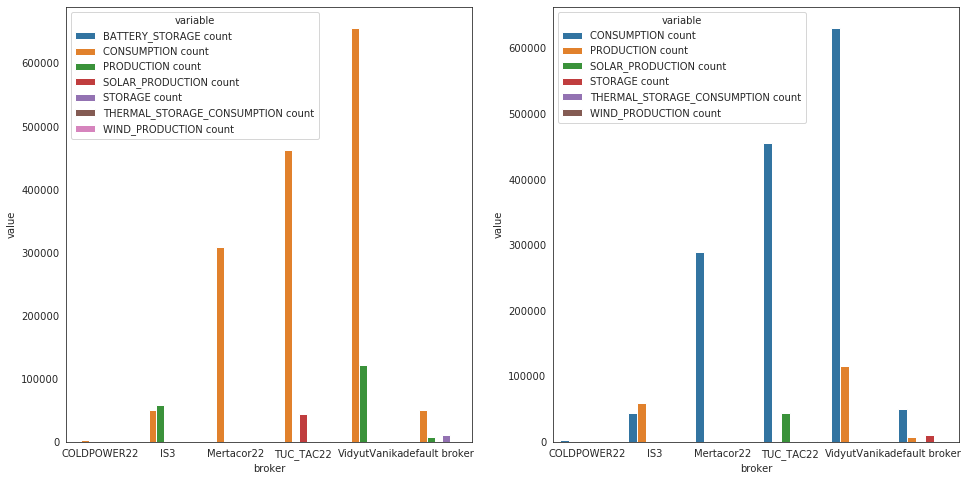

In [66]:
tf_type_subs = tf_transactions[['broker-name', 'tariff-type', "transaction-type"
                              , 'customer-name', 'customer-count']].copy()
#tf_type_dist = tf_type_dist[tf_type_dist['customer-name'] == 'residential_ev']

tf_type_subs = tf_type_subs[(tf_type_subs["transaction-type"] == "SIGNUP") | (tf_type_subs["transaction-type"] == "WITHDRAW")]
tf_type_subs = tf_type_subs[["broker-name", "tariff-type"
                             , "transaction-type", "customer-count"]
                           ].groupby(by = ['broker-name', "tariff-type", "transaction-type" ]).sum()
tf_type_subs = tf_type_subs.reset_index()
tf_type_subs.columns = ['broker', 'tariff-type', 'transaction-type', 'count']

subs_sign = tf_type_subs[tf_type_subs["transaction-type"] == "SIGNUP"][['broker', 'tariff-type', 'count']].copy()
subs_withdraw = tf_type_subs[tf_type_subs["transaction-type"] == "WITHDRAW"][['broker', 'tariff-type', 'count']].copy()

subs_sign = subs_sign.pivot(columns='tariff-type', index='broker')
subs_sign.columns = subs_sign.columns.swaplevel().map(' '.join)
subs_sign = subs_sign.replace(np.nan,0)
subs_sign = subs_sign.reset_index()

subs_withdraw = subs_withdraw.pivot(columns='tariff-type', index='broker')
subs_withdraw.columns = subs_withdraw.columns.swaplevel().map(' '.join)
subs_withdraw = subs_withdraw.replace(np.nan,0)
subs_withdraw = subs_withdraw.reset_index()

subs_sign_count = subs_sign.loc[:, subs_sign.columns != "broker"]
subs_withdraw_count = subs_withdraw.loc[:, subs_withdraw.columns != "broker"]

df_melt_subs_sign = pd.melt(subs_sign, id_vars=['broker'], value_vars=subs_sign_count.columns.tolist())
df_melt_subs_withdraw = pd.melt(subs_withdraw, id_vars=['broker'], value_vars=subs_withdraw_count.columns.tolist())


f, axes = plt.subplots(1,2, figsize = (16,8))

sns.barplot(x='broker', y='value', hue='variable', data=df_melt_subs_sign, ax = axes[0])
sns.barplot(x='broker', y='value', hue='variable', data=df_melt_subs_withdraw, ax = axes[1])


In [200]:
tf_transactions['customer-name'].unique()

array(['Village 1 NS Base', 'Village 1 NS Controllable',
       'Village 1 SS Base', 'Village 1 SS Controllable',
       'Village 2 NS Base', 'Village 2 NS Controllable',
       'Village 2 SS Base', 'Village 2 SS Controllable', 'BrooksideHomes',
       'CentervilleHomes', 'DowntownOffices', 'EastsideOffices',
       'FrostyStorage', 'HextraChemical', 'MedicalCenter-1',
       'MedicalCenter-2', 'SunnyhillSolar1', 'SunnyhillSolar2',
       'WindmillCoOp-1', 'WindmillCoOp-2', 'SolarLeasing',
       'OfficeComplex 1 NS Base', 'OfficeComplex 1 NS Controllable',
       'OfficeComplex 1 SS Base', 'OfficeComplex 1 SS Controllable',
       'OfficeComplex 2 NS Base', 'OfficeComplex 2 NS Controllable',
       'OfficeComplex 2 SS Base', 'OfficeComplex 2 SS Controllable',
       'seafood-1', 'seafood-2', 'freezeco-1', 'freezeco-2', 'freezeco-3',
       'residential_ev', 'sf2', 'sf3', 'fc2', 'fc3', 'b1', 'b2', 'b3',
       'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b13',
       'b14'

In [113]:
tf_type_dist = tf_transactions[['broker-name', 'tariff-id', 'tariff-type', 'transaction-kWh', 'customer-name', 'customer-count']].copy()

tf_type_count = pd.DataFrame(tf_type_dist[['broker-name', 'tariff-type', 'tariff-id']].groupby(by = ['broker-name', 'tariff-type'])['tariff-id'].nunique())
tf_type_count = tf_type_count.reset_index()
tf_type_count.columns = ['broker', 'tariff-type', 'count']

tf_type_energy = pd.DataFrame(tariff_type_dist[['broker-name', 'tariff-type', 'transaction-kWh']].groupby(by = ['broker-name', 'tariff-type']).sum())
tf_type_energy = tf_type_energy.reset_index()
tf_type_energy.columns = ['broker', 'tariff-type', 'energy']

# Use melt to reshape the dataframe
df_melt_count = pd.melt(tf_type_count, id_vars=['broker'], value_vars=['upReg', 'downReg'])
df_melt_energy = pd.melt(tf_type_energy, id_vars=['broker'], value_vars=['pUp_fromBroker', 'profit_x', 'pDown_toBroker', 'profit_y'])


# Create a bar plot

f, axes = plt.subplots(3,1, figsize = (20,24))

a = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_energy, ax=axes[0])
b = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_profit, ax=axes[1])
c = sns.barplot(x='broker', y='value', hue='variable', data=df_melt_perKwh, ax=axes[2])

,broker,tariff-type,count
0,COLDPOWER22,CONSUMPTION,30
1,COLDPOWER22,PRODUCTION,29
2,IS3,CONSUMPTION,115
3,IS3,PRODUCTION,19
4,Mertacor22,CONSUMPTION,17
5,TUC_TAC22,CONSUMPTION,19
6,TUC_TAC22,SOLAR_PRODUCTION,6
7,TUC_TAC22,THERMAL_STORAGE_CONSUMPTION,1
8,TUC_TAC22,WIND_PRODUCTION,3
9,VidyutVanika,BATTERY_STORAGE,1


In [64]:
# .groupby(by = ['broker-name', 'tariff-id', 'tariff-type', 'customer-name', 'customer-count']).sum()
tariff_type_dist = tf_transactions[['broker-name', 'tariff-id', 'tariff-type', 'transaction-kWh', 'customer-name', 'customer-count']].copy()
testdf = (tariff_type_dist[['broker-name', 'tariff-id']]
       .groupby(['broker-name', 'tariff-id'], as_index=False).size())


testdf = pd.DataFrame(testdf).reset_index()
testdf

,broker-name,tariff-id,0
0,COLDPOWER22,200000009,1
1,COLDPOWER22,200000012,43
2,COLDPOWER22,200000015,28
3,COLDPOWER22,200000158,345
4,COLDPOWER22,200000441,121
...,...,...,...
386,VidyutVanika,302007471,1
387,VidyutVanika,302007520,73
388,default broker,1884,118
389,default broker,1887,972


In [38]:
tariff_type_dist = tf_transactions[['broker-name', 'tariff-id', 'tariff-type', 'transaction-kWh', 'customer-name', 'customer-count']].groupby(by = ['broker-name', 'tariff-id', 'tariff-type', 'customer-name', 'customer-count']).sum().copy()
tariff_type_dist[['broker-name', 'tariff-id']].groupby(['broker-name', 'tariff-id']).count()





KeyError: "None of [Index(['broker-name', 'tariff-id'], dtype='object')] are in the [columns]"